In [ ]:
### Librerías
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time as time
import astropy.units as u

In [256]:
### Constantes
GM = 398600.4405*u.km**3*u.s**(-2)  # Parametro gravitacional

### Parametros orbitaels
R = 6378.1 * u.km                   # Radio terretres
a = 1.30262 * R                     # Semieje mayor
e = 0.16561                         # Excentricidad
w = 15 * u.deg                      # Argumento de periapsis
tp = time("2025-03-31T00:00:00")    # Tiempo de paso por el pariapsis

In [232]:
### Función *position*
def solve_keppler(t):
    # Diferencia de tiempo [s]
    dt = (t-tp).to("s")
    # Anomalía media [rad]
    L = np.sqrt(GM / (a**3)) * dt
    L = L.value
    # Anomalía excéntrica inicial
    E = L
    # Busqueda por Newton-Raphson de E asociada a L
    # Considera 1e-12 ~ 0
    epsilon = 1e-12
    while abs(E - e*np.sin(E) - L) > epsilon:
        # Derivada analítica anomalía excentríca
        dE = 1 - e*np.cos(E) 
        # Calculo iterativo anomalía excentríca
        E = E - (E - e*np.sin(E) - L) / (dE)
    # Transformación anomalía excentríca a anomalía verdadera
    f = 2 * np.arctan(np.sqrt((1+e)/(1-e)) * np.tan(E/2)) * u.rad
    return f

def position(t):
    # Obtiene la anomalía verdadera a partir del tiempo 
    f = solve_keppler(t)
    # Calculo de la distancia
    r = a*(1-e**2) / (1 + e*np.cos(f))
    return r.value, (f+w).value


orbit_date = time("2025-04-01T00:00:00")
r, f = position(orbit_date)
print(f"El satélite se encuentra el {orbit_date.iso} en:\nr(t)= {r:.3f} km\tφ(t)= {np.degrees(f):.3f}°")



El satélite se encuentra el 2025-04-01 00:00:00.000 en:
r(t)= 9658.409 km	φ(t)= 185.597°


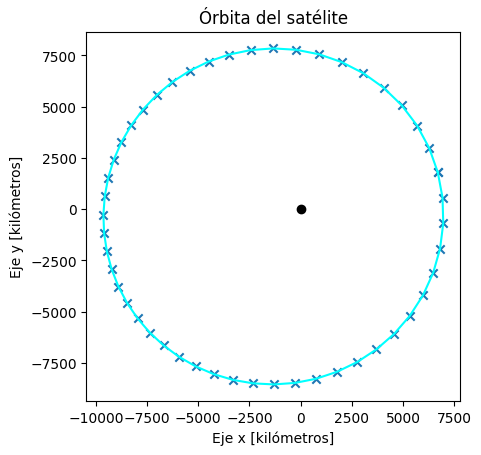

In [261]:
### Función *orbit*
def orbit():
    n = 50             # Numero de puntos
    x = np.zeros(n)     # Array eje x
    y = np.zeros(n)     # Array eje y 
    for i in range(n):
        r, f = position(tp + ((i / (n -1)) * np.sqrt((a**3) / GM) * 2*np.pi).to(u.d))
        x[i] = r*np.cos(f)
        y[i] = r*np.sin(f)
    
    plt.plot(x, y, color='cyan')
    plt.scatter(x, y, marker='x')
    plt.plot(0, 0, marker='o', color='k')
    plt.gca().set_aspect('equal')
    plt.title("Órbita del satélite")
    plt.xlabel("Eje x [kilómetros]")
    plt.ylabel("Eje y [kilómetros]")
    plt.show()

orbit()

In [346]:
### Función *date*
def distance(f):
    return a*(1-e**2) / (1+e*np.cos(f)) - r0


def date(r0):
    r_max = a * (1 + e)
    r_min = a * (1 - e)
    if r0 > r_max or r0 < r_min:
        print(f"{r0} está fuera de los límites [{r_min}, {r_max}]")
        return None

    epsilon = 1e-8 * u.km
    r_middle = a * np.sqrt(1 - e**2)
    T = (2 * np.pi * np.sqrt(a**3 / GM)).to(u.d)

    # Estimación inicial de f
    if r0 > r_middle:
        f = solve_keppler(tp + 0.25 * T)
    else:
        f = solve_keppler(tp + 0.01 * T)

    df = np.pi / 1e3 * u.rad

    while abs(distance(f)) >= epsilon:
        dr = (distance(f + df) - distance(f - df)) / (2 * df)
        f = f - distance(f) / dr

    # f a E a L a t
    f_val = f.value
    E = 2 * np.arctan(np.sqrt((1 - e)/(1 + e)) * np.tan(f_val / 2))
    L = E - e * np.sin(E)
    n = np.sqrt(GM / a**3)
    dt = (L / n).to(u.s)
    t = tp + dt

    return t, distance(f)

r0 = 1.5*R
t = date(r0)
print(f"La distancia {r0:.2f} es alcanzada en el momento {t[0]}.\n Se encontró con un error de {t[1]}")

La distancia 9567.15 km es alcanzada en el momento 2025-03-31T00:53:09.855.
 Se encontró con un error de 7.657945388928056e-10 km
